In [1]:
import numpy as np
import pandas as pd 
import os
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR,LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings('ignore')

## 获取数据，分层划分数据集与测试集

In [2]:
data = pd.read_csv('./housing.csv')

data['data_income'] = pd.cut(data['median_income'],
                            bins = [0,1.5, 3, 4.5, 6, np.inf],
                            labels=[1,2,3,4,5])

s = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=1)
for train, test in s.split(data,data['data_income']):
    train_set , test_set = data.loc[train], data.loc[test]
    
for i in (train_set,test_set):
    i.drop('data_income',axis=1, inplace = True)
    
train_x = train_set.drop('median_house_value',axis=1)
y_train = train_set['median_house_value'].copy()  
housing_labels = y_train.copy()

x_test= test_set.drop('median_house_value',axis=1)
test_x = x_test.copy()
test_y = test_set["median_house_value"].copy()

In [4]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,data_income
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


## 可视化分析
查看特征数据分布是否相对集中

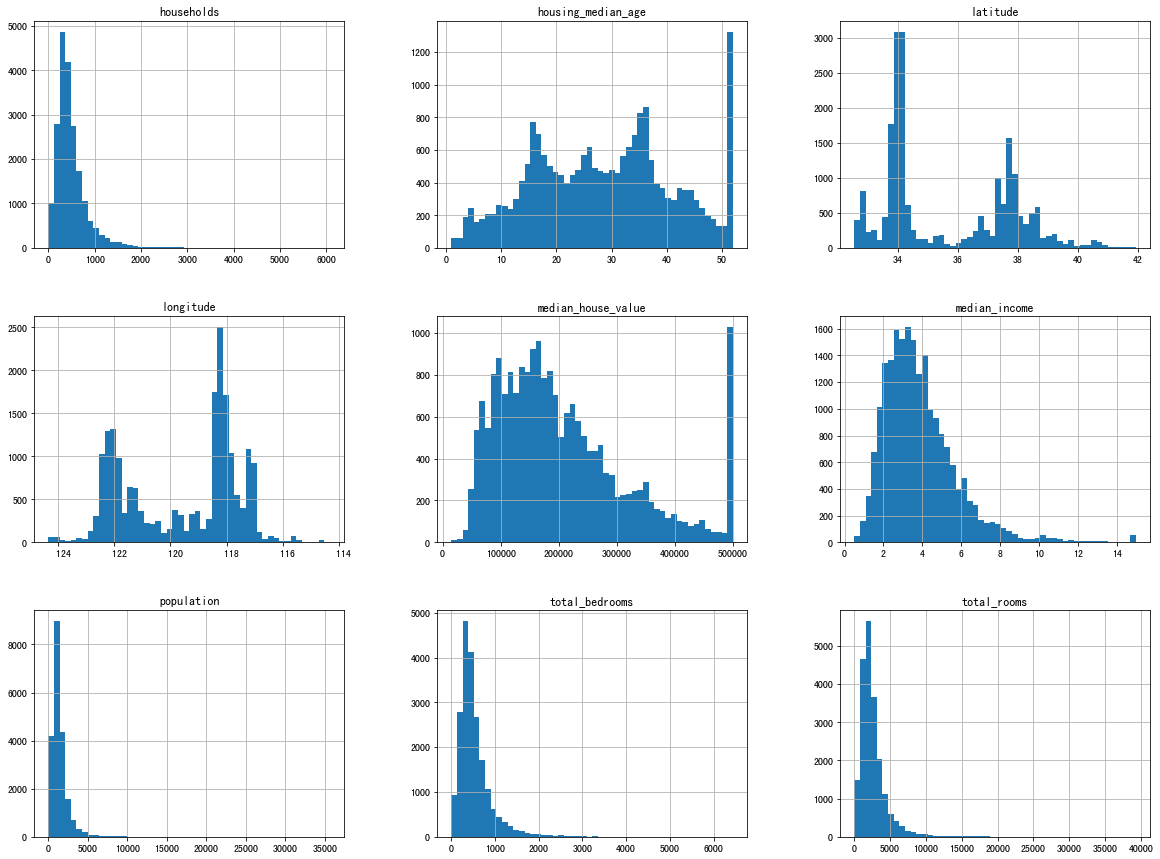

In [3]:
data.hist(bins=50,figsize=(20,15))
plt.show()

In [7]:
data.corr()['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

## 组合具有相关性的特征

In [8]:
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(train_x.columns).index(col)    
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

## 训练模型

In [9]:
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

In [10]:
train_num_x = train_x.drop('ocean_proximity', axis=1)
num_attribs = list(train_num_x)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', OldDataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', OldDataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

housing_prepared = full_pipeline.fit_transform(train_x)

In [11]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
x_prepared = full_pipeline.transform(test_x)
score = lin_reg.score(x_prepared, test_y)
print("线性回归：", score)

线性回归： 0.6615136467099778


In [12]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)
score = tree_reg.score(x_prepared,test_y)
print("决策树：",score)

决策树： 0.632637545638831


In [13]:
svr = SVR(kernel="rbf",C=100000)
svr.fit(housing_prepared, housing_labels)
score = svr.score(x_prepared,test_y)
print("SVM:",score)

SVM: 0.7661342560803278


In [14]:
rf = RandomForestRegressor(criterion="mse",max_depth=50)
rf.fit(housing_prepared, housing_labels)
score = rf.score(x_prepared,test_y)
print("随机森林：",score)

随机森林： 0.8028246997278392


In [15]:
boost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())
boost.fit(housing_prepared, housing_labels)
score = boost.score(x_prepared,test_y)
print("boost:",score)

boost: 0.8286786550878783
